In [1]:
!pip install seaborn
!pip install --user corner
!{sys.executable} -m pip install --user corner
!pip install iminuit
!pip install fitsio
!pip install ipywidgets
!pip install emcee

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: Loading egg at /global/common/software/nersc9/pytorch/2.6.0/lib/python3.12/site-packages/torchvision-0.21.0+7af6987-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /global/common/software/nersc9/pytorch/2.6.0/lib/python3.12/site-packages/setuptools-75.8.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /global/common/software/nersc9/pytorch/2.6.0/lib/python3.12/site-packages/pillow-11.1.0-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package install

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, random_split
import seaborn as sns
import sys

import corner 

In [3]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim: int):
        super(Autoencoder, self).__init__()
         
        
        # Encoder (capas progresivamente más pequeñas)
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(625,312),
            nn.ReLU(),
            nn.Linear(312, 156), 
            nn.ReLU(),
            nn.Linear(156, 78),
            nn.ReLU(),
            nn.Linear(78, latent_dim)

            
        )
        
        # Decoder (capas simétricas al encoder)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 78),
            nn.ReLU(),
            nn.Linear(78, 156),
            nn.ReLU(),
            nn.Linear(156, 312),
            nn.ReLU(),
            nn.Linear(312, 625),
            nn.Softmax(dim=1),
            nn.Unflatten(1, (1, 25, 25)),  # Volver a la forma original
            

        )

    def forward(self, x: torch.Tensor): # x es el tensor de entrada  
        z = self.encoder(x) # El resultado de z es el espacio latente (lo que aprendió la red)
        out = self.decoder(z) #out es la versión reconstruida de la imagen 
        return out

In [4]:
dic = pickle.load(open('/global/cfs/cdirs/desc-wl/users/aplazas/trainingDataSetHSC_RC2.pkl', 'rb'))
data=pd.DataFrame(dic)

#Tener en cuenta que las imagenes ya están normalizadas 
all_images= np.array(data.iloc[0])
# Convierte a un array NumPy 3D: (N, 25, 25)
all_images = np.stack(all_images)  
# Agrega un canal para PyTorch: (N, 1, 25, 25)
all_images = np.expand_dims(all_images, axis=1)

tensor_images = torch.tensor(all_images, dtype=torch.float32)

In [5]:
# Dimensión del espacio latente
latent_dim = 16

# Dispositivo
device = torch.device("cpu")

# Modelo
autoencoder = Autoencoder(latent_dim=latent_dim).to(device)


In [6]:
autoencoder = Autoencoder(latent_dim)  # tu clase
autoencoder.load_state_dict(torch.load("autoencoder_parameterslr.pth"))
autoencoder.eval()  # importante para que funcione en modo inferencia

Autoencoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=625, out_features=312, bias=True)
    (2): ReLU()
    (3): Linear(in_features=312, out_features=156, bias=True)
    (4): ReLU()
    (5): Linear(in_features=156, out_features=78, bias=True)
    (6): ReLU()
    (7): Linear(in_features=78, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=78, bias=True)
    (1): ReLU()
    (2): Linear(in_features=78, out_features=156, bias=True)
    (3): ReLU()
    (4): Linear(in_features=156, out_features=312, bias=True)
    (5): ReLU()
    (6): Linear(in_features=312, out_features=625, bias=True)
    (7): Softmax(dim=1)
    (8): Unflatten(dim=1, unflattened_size=(1, 25, 25))
  )
)

In [7]:
autoencoder.eval()

with torch.no_grad():
    # Enviar todas las imágenes al mismo dispositivo que el modelo
    x_all = tensor_images.to(device)  # (N, 1, 25, 25)
    
    # Obtener los vectores en el espacio latente
    z_all = autoencoder.encoder(x_all)  # (N, latent_dim)

# Convertir a NumPy
z_all_np = z_all.cpu().numpy()  # (N, latent_dim)

In [8]:
visit = np.array(data.iloc[15])
xFoV=np.array(data.iloc[11])
yFoV=np.array(data.iloc[12])

In [9]:
# Cornerplot de los datos completos
'''x_filtered = xFoV
y_filtered = yFoV
z_filtered = z_all_np  
    
corner_fig = corner.corner(z_filtered, 
                               labels=[f"z{i}" for i in range(z_filtered.shape[1])],
                               max_n_ticks=3)
    
plt.show()'''

'x_filtered = xFoV\ny_filtered = yFoV\nz_filtered = z_all_np  \n    \ncorner_fig = corner.corner(z_filtered, \n                               labels=[f"z{i}" for i in range(z_filtered.shape[1])],\n                               max_n_ticks=3)\n    \nplt.show()'

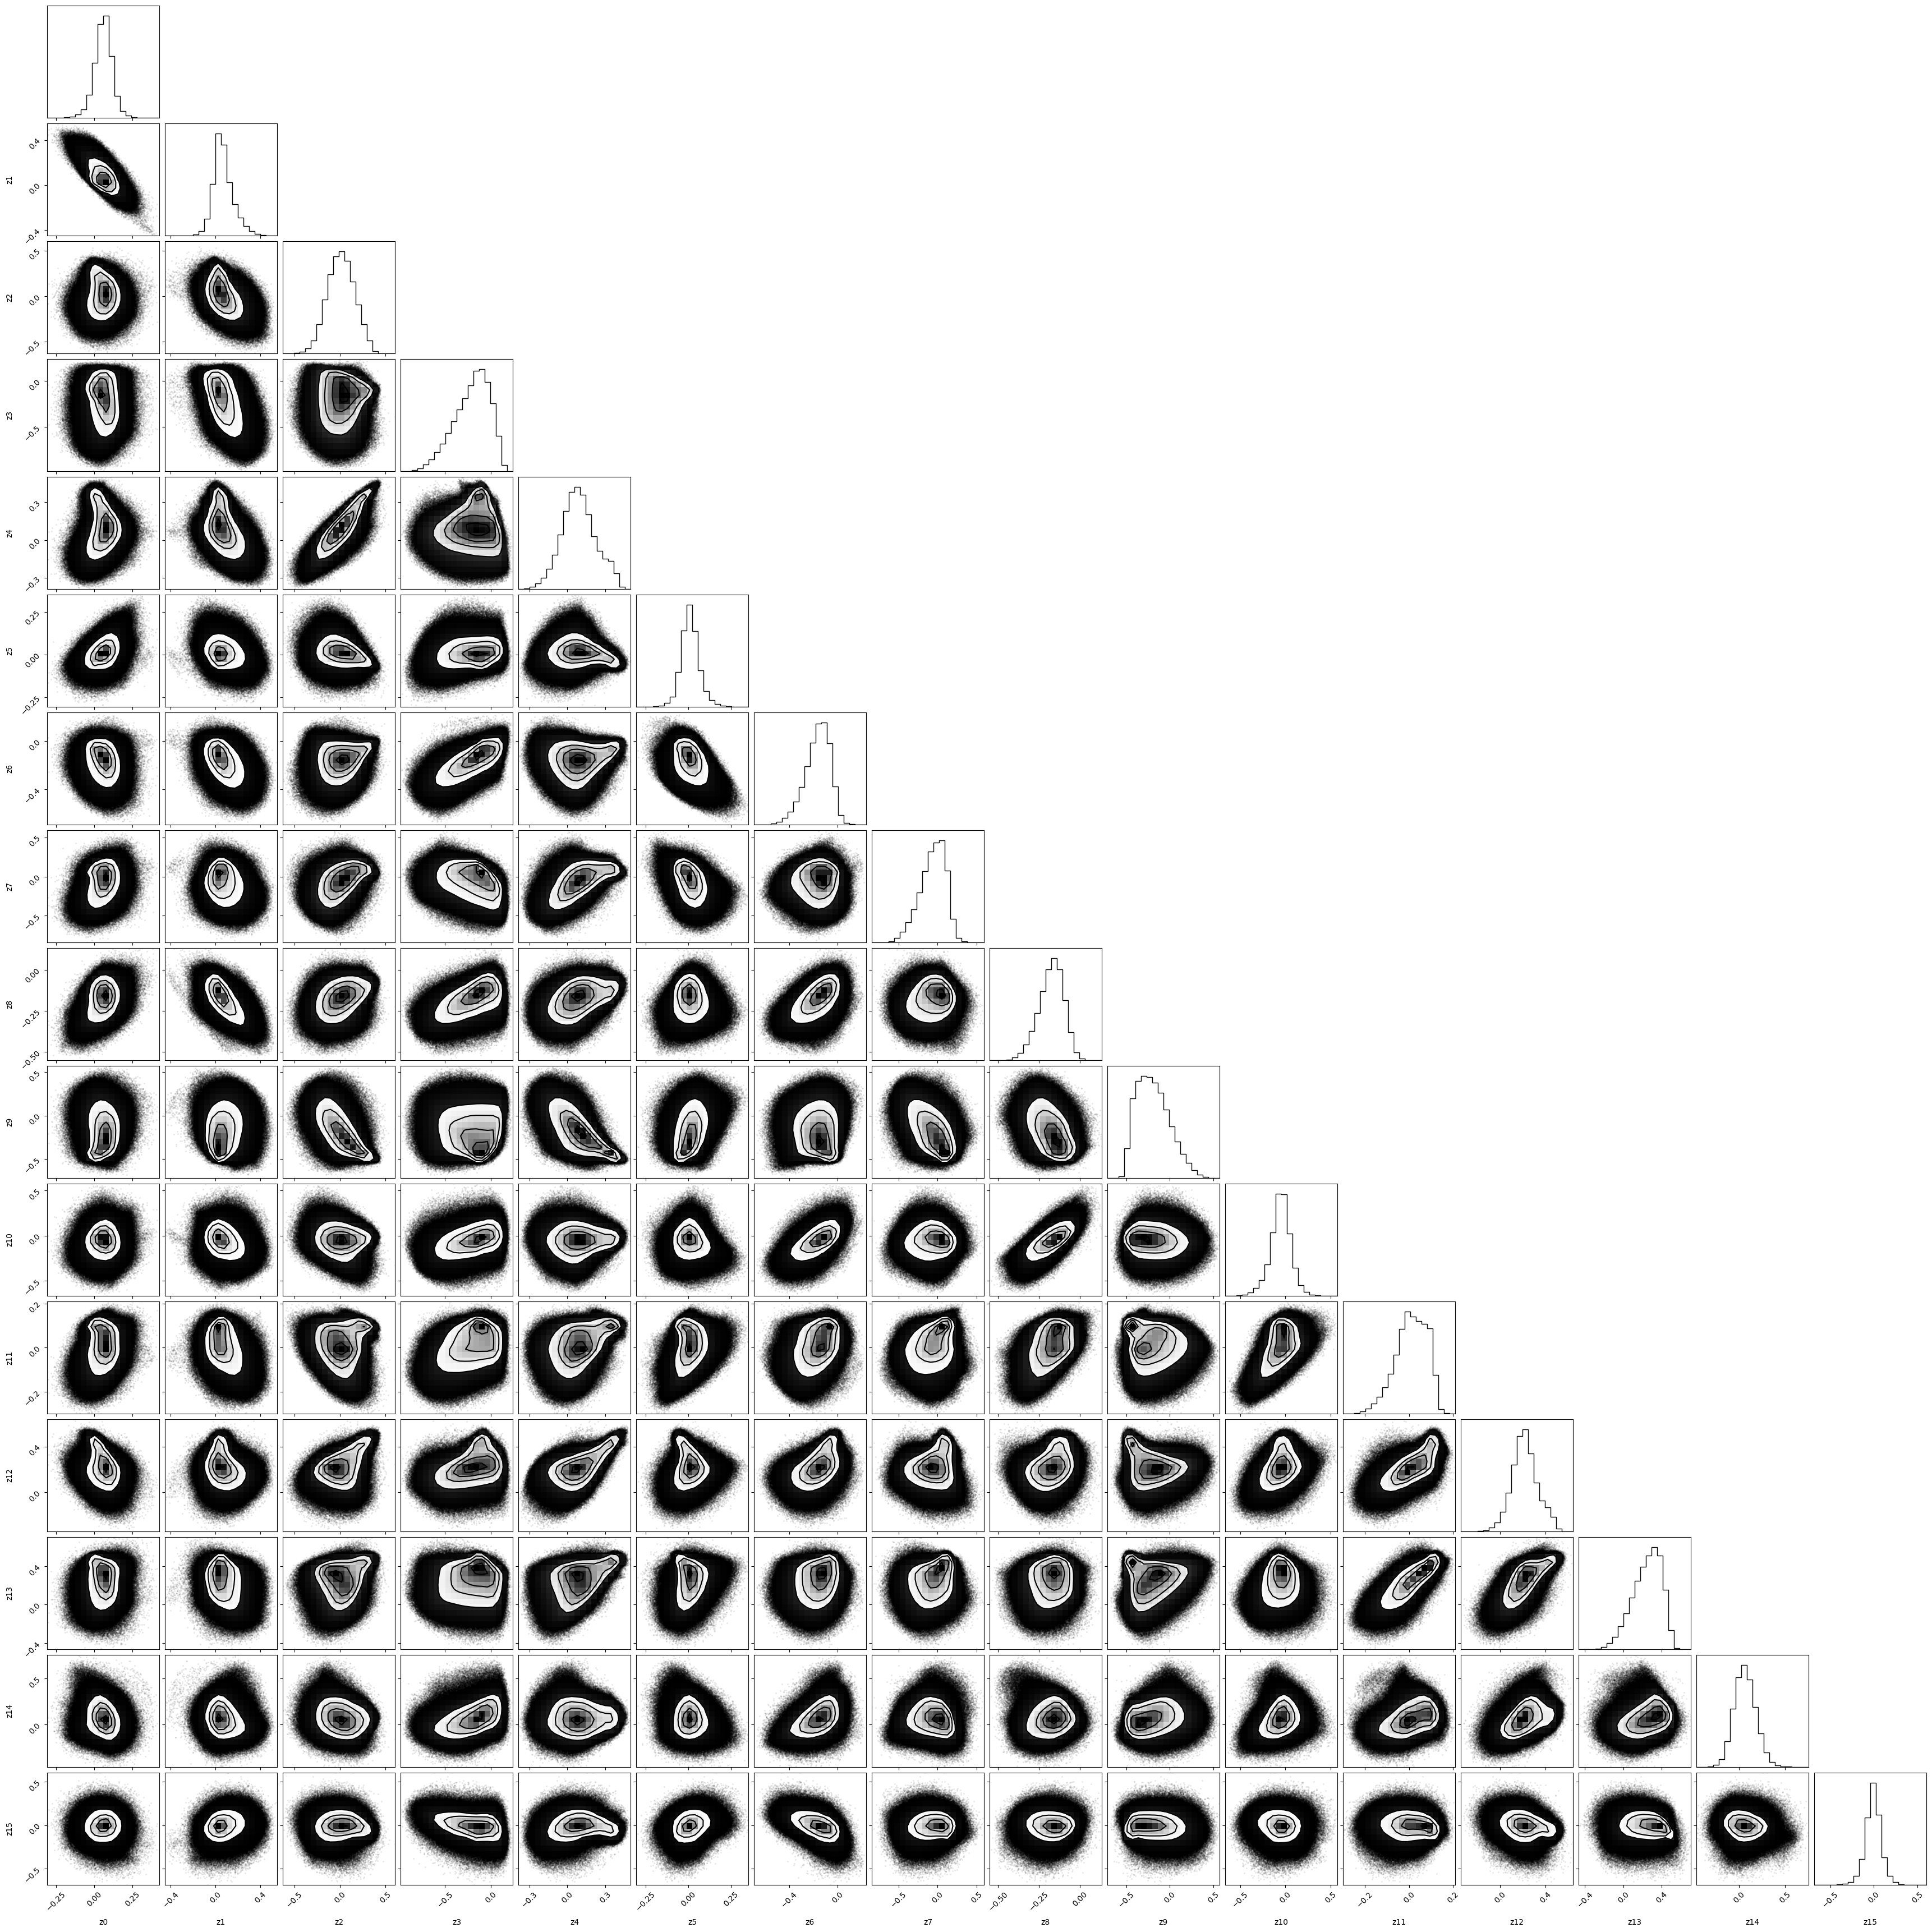

In [10]:
# 1. Centro del espacio latente
center = np.mean(z_all_np, axis=0)

# 2. Distancias al centro
distances = np.linalg.norm(z_all_np - center, axis=1)

# Calcula media y desviación estándar
mean_dist = np.mean(distances)
std_dist = np.std(distances)

# Considerar como outliers los que estén a más de 3 sigmas
mask = distances < (mean_dist + 1.5 * std_dist)

z_clean = z_all_np[mask]
xFoV_clean = xFoV[mask]
yFoV_clean = yFoV[mask]


visit = np.array(visit)

# Aplicar el filtro a todas tus variables
x_filtered = xFoV_clean
y_filtered = yFoV_clean
z_filtered = z_clean  # (n_samples_filtrados, latent_dim)
    
corner_fig = corner.corner(z_filtered, 
                               labels=[f"z{i}" for i in range(z_filtered.shape[1])],
                               max_n_ticks=3)

plt.savefig('parameters_all_data.png')
plt.show()



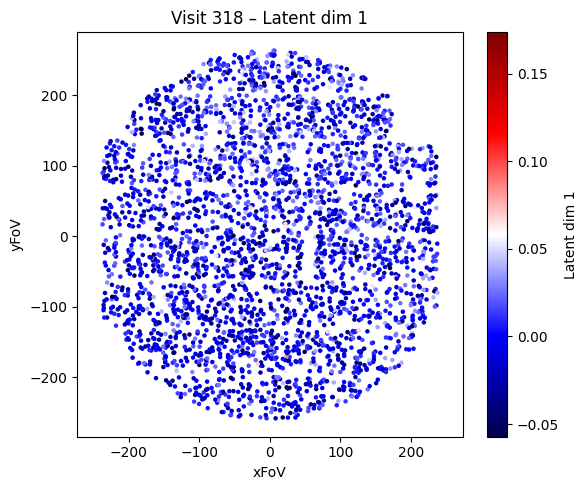

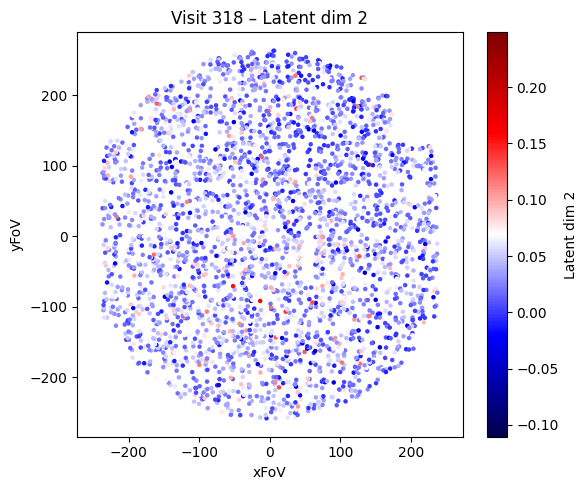

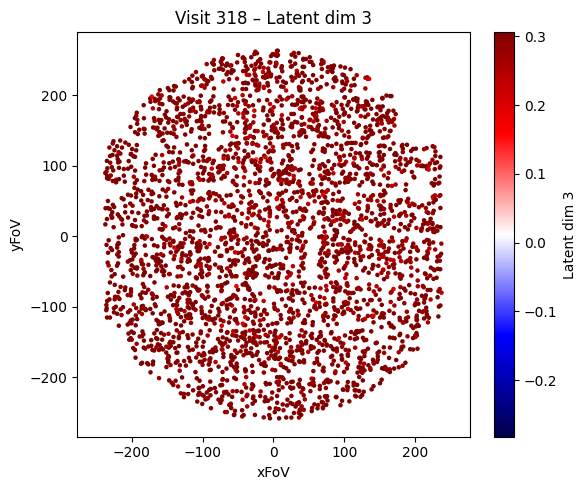

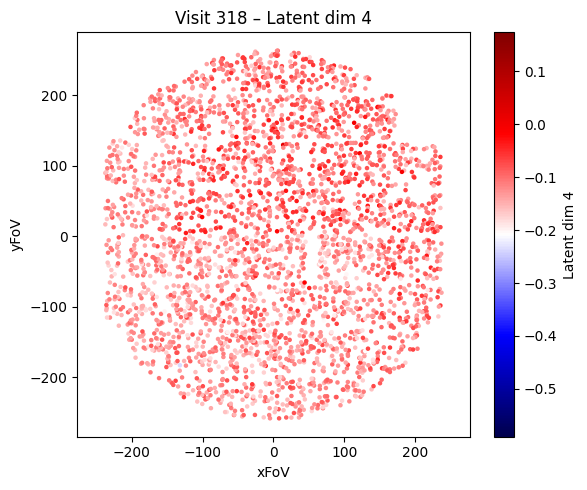

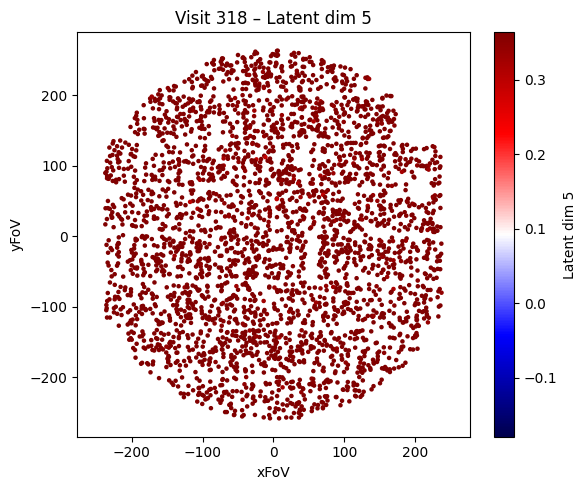

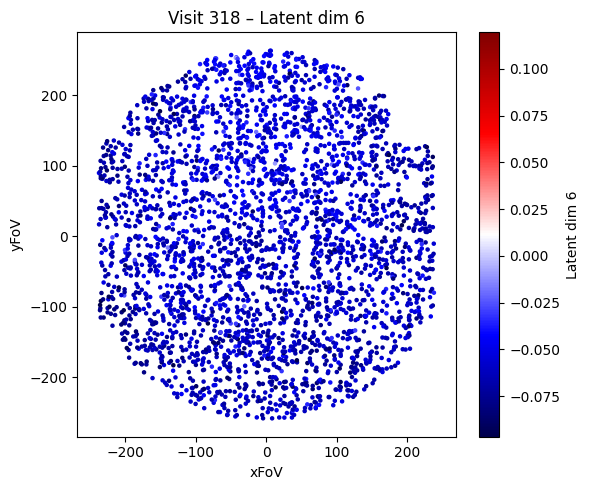

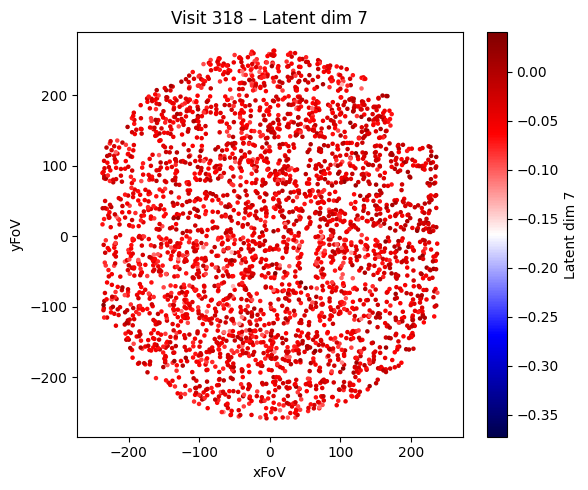

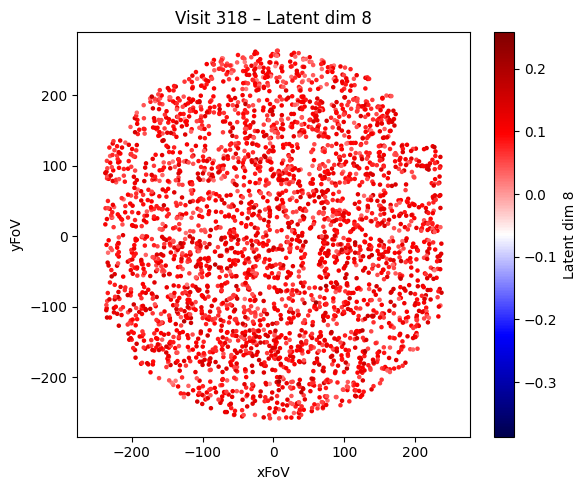

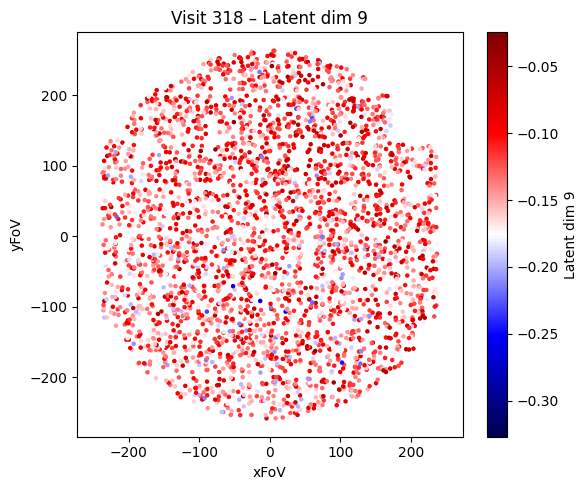

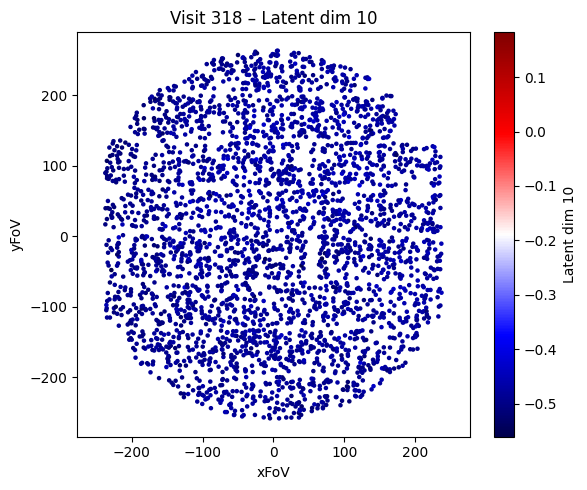

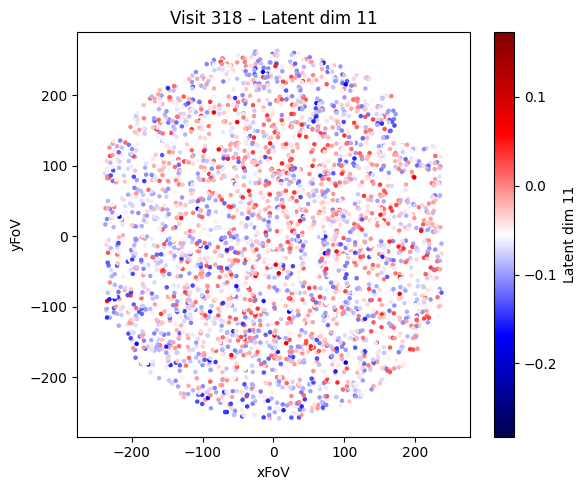

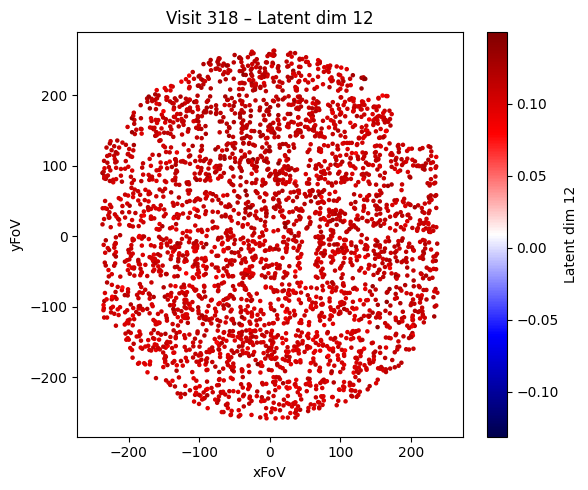

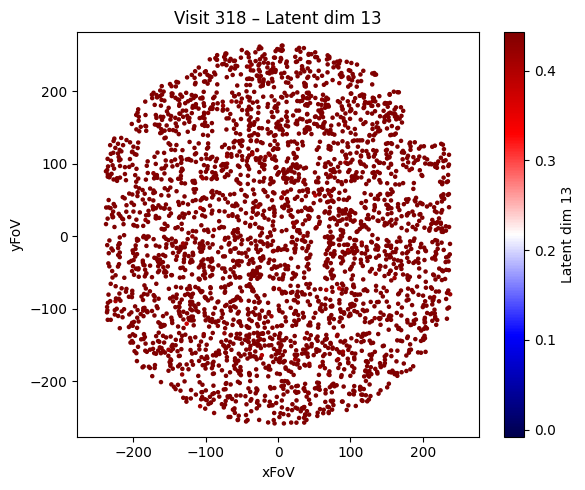

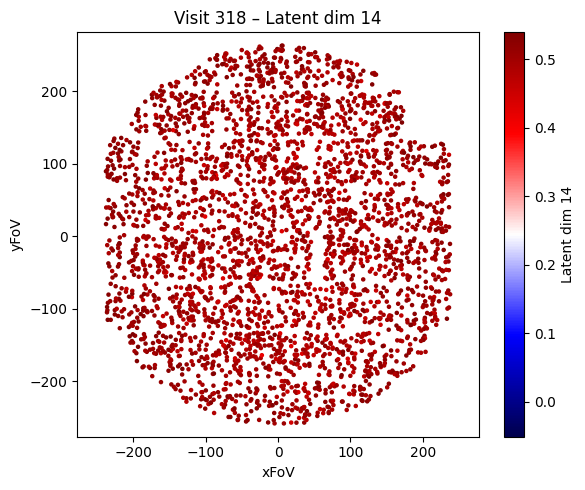

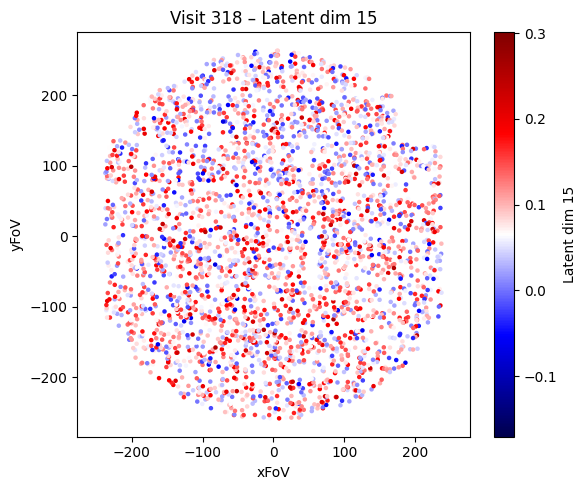

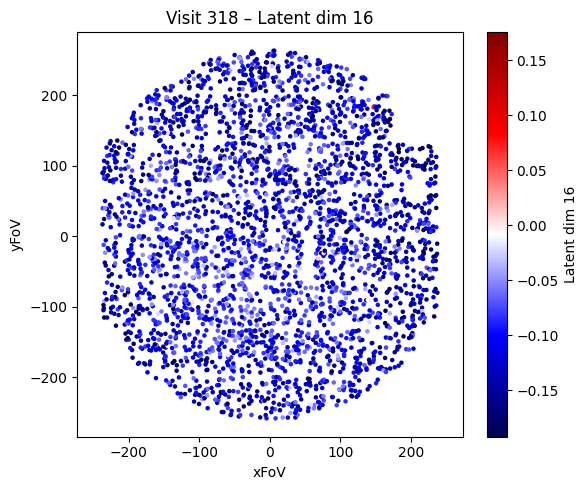

In [11]:
visit = np.array(data.iloc[15])


# Obtener las representaciones latentes
autoencoder.eval()
with torch.no_grad():
    x_all = tensor_images.to(device)
    z_all = autoencoder.encoder(x_all)

# Convertir a NumPy
z_all_np = z_all.cpu().numpy()  # (N, latent_dim)


# xFoV, yFoV y visit son arrays de NumPy
xFoV = np.array(xFoV)
yFoV = np.array(yFoV)
visit = np.array(visit)

# 4. IDs únicos de visita
unique_visits = np.unique(visit)


# 1. Centro del espacio latente
center = np.mean(z_all_np, axis=0)

# 2. Distancias al centro
distances = np.linalg.norm(z_all_np - center, axis=1)

# Calcula media y desviación estándar
mean_dist = np.mean(distances)
std_dist = np.std(distances)

# Filtro de distancia
mask = distances < (mean_dist + 1.5 * std_dist)

z_filtered = z_all_np[mask]
x_filtered = xFoV[mask]
y_filtered = yFoV[mask]
visit_filtered = visit[mask]

unique_visits = np.unique(visit_filtered)

v_id=318
mask1 = (visit_filtered == v_id)


for j in range(z_filtered.shape[1]):  # para cada componente latente

    mean = np.mean(z_filtered[:, j])
    std = np.std(z_filtered[:, j])
    vmin = mean - 2 * std
    vmax = mean + 2 * std

    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(x_filtered[mask1], y_filtered[mask1], c=z_filtered[mask1, j], cmap='seismic', s=5, vmin=vmin, vmax=vmax)
    plt.colorbar(scatter, label=f"Latent dim {j+1}")
    plt.xlabel("xFoV")
    plt.ylabel("yFoV")
    plt.title(f"Visit 318 – Latent dim {j+1}")
    plt.axis("equal")
    plt.tight_layout()
    plt.show()

In [12]:
import sys
import os
sys.path.append(os.path.abspath('..'))

print(os.path.abspath('..'))

/global/u1/d/dayana/treegp


In [13]:
import pylab as plt
from matplotlib import gridspec
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact
import itertools

from treegp import AnisotropicRBF, eval_kernel
import treegp
from treegp import GPInterpolation



In [14]:
def gp_regression(x, new_x, y, kernel, y_err=None):
    
    if y_err is None:
        y_err =np.ones_like(y) *1e-10

    gp = treegp.GPInterpolation(kernel=kernel, optimizer='none', 
                                normalize=True, white_noise=0.001, p0=None,
                                n_neighbors=10, average_fits=None, nbins=20, 
                                min_sep=None, max_sep=None)
    gp.initialize(x, y, y_err=y_err)
    y_predict, y_cov = gp.predict(new_x, return_cov=True)
    y_std = np.sqrt(np.diag(y_cov))
    return gp, y_predict, y_std


def get_correlation_length_matrix(size, g1, g2):
    if abs(g1)>1:
        g1 = 0
    if abs(g2)>1:
        g2 = 0
    g = np.sqrt(g1**2 + g2**2)
    q = (1-g) / (1+g)
    phi = 0.5 * np.arctan2(g2,g1)
    rot = np.array([[np.cos(phi), np.sin(phi)],
                    [-np.sin(phi), np.cos(phi)]])
    ell = np.array([[size**2, 0],
                    [0, (size * q)**2]])
    L = np.dot(rot.T, ell.dot(rot))
    return L

# 1. Centro del espacio latente
center = np.mean(z_all_np, axis=0)

# 2. Distancias al centro
distances = np.linalg.norm(z_all_np - center, axis=1)

# Calcula media y desviación estándar
mean_dist = np.mean(distances)
std_dist = np.std(distances)

mask = distances < (mean_dist + 3 * std_dist)

z_filtered = z_all_np[mask]
x_filtered = xFoV[mask]
y_filtered = yFoV[mask]
visit_filtered = visit[mask]

# Ahora sí:
j = 0  # componente latente
visit_id = 318
mask1 = (visit_filtered == visit_id) 

# Aplicar correctamente a los datos filtrados
theta_x = x_filtered[mask1]
theta_y = y_filtered[mask1]
XXX = np.stack((theta_x, theta_y), axis=1)
YYY = z_filtered[mask1, j]


# Colores normalizados para ver bien
mean = np.mean(YYY)
std = np.std(YYY)
vmin = mean - 2 * std
vmax = mean + 2 * std


YYY_err = np.full_like(YYY, std*0.1)  

# function to interactivly plot gaussian random fields realization. 
@interact(sigma = widgets.FloatSlider(value=2., min=0.01, max=5.0, step=0.01, description='$\sigma$:',
          disabled=False,
          continuous_update=False,
          orientation='horizontal',
          readout=True,
          readout_format='.2f'), 
          size = widgets.FloatSlider(value=1, min=0.01, max=10.0, step=0.01, description='$l$:',
          disabled=False,
          continuous_update=False,
          orientation='horizontal',
          readout=True,
          readout_format='.2f'),
          g1 = widgets.FloatSlider(value=0, min=-0.99, max=0.99, step=0.01, description='$g_1$:',
          disabled=False,
          continuous_update=False,
          orientation='horizontal',
          readout=True,
          readout_format='.2f'),
          g2 = widgets.FloatSlider(value=0, min=-0.99, max=0.99, step=0.01, description='$g_2$:',
          disabled=False,
          continuous_update=False,
          orientation='horizontal',
          readout=True,
          readout_format='.2f'),
          kernel = widgets.Dropdown(options=['AnisotropicRBF'],
                                  value='AnisotropicRBF',
                                  description='Kernel:',
                                  disabled=False,))
def plot_predict_2D(sigma, size, g1, g2, kernel):
    
    gs = gridspec.GridSpec(1, 3, width_ratios=[1.3, 1.3, 1])
    
    plt.figure(figsize=(22,6))
    plt.subplots_adjust(wspace=0.2)
    plt.subplot(gs[0])

    plt.scatter(XXX[:,0], XXX[:,1], c=YYY, s=5, cmap=plt.cm.seismic, vmin=vmin, vmax=vmax)
    cb = plt.colorbar()
    cb.set_label('Latent dim 1', fontsize=20)
    plt.xlabel('xFov', fontsize=20)
    plt.ylabel('yFov', fontsize=20)
    plt.title('Visita 318', fontsize=20)
    
    L = get_correlation_length_matrix(size, g1, g2)
    inv_L = np.linalg.inv(L)
    Kernel = "%f"%(sigma**2) + " * AnisotropicRBF(invLam={0!r})".format(inv_L)
    plt.subplot(gs[1])

    NPOINT = 150
    x_min, x_max = XXX[:, 0].min(), XXX[:, 0].max()
    y_min, y_max = XXX[:, 1].min(), XXX[:, 1].max()
    
    grid_x = np.linspace(x_min, x_max, NPOINT)
    grid_y = np.linspace(y_min, y_max, NPOINT)
    new_x, new_y = np.meshgrid(grid_x, grid_y)
    coord = np.stack([new_x.ravel(), new_y.ravel()], axis=1)
    
    # 2. Proceso gaussiano
    gp, y_pred, y_std = gp_regression(XXX, coord, YYY, Kernel, y_err=YYY_err)

    
    # 3. Convertir predicción a forma de imagen para graficar
    y_pred = y_pred.reshape((NPOINT, NPOINT))
    
    # 4. Mostrar imagen interpolada
    plt.imshow(y_pred, extent=[x_min, x_max, y_min, y_max],
               origin='lower', cmap=plt.cm.seismic, vmin=vmin, vmax=vmax)
    cb = plt.colorbar()
    cb.set_label('Latent dim 1', fontsize=20)
    plt.xlabel('xFov', fontsize=20)
    plt.ylabel('yFov', fontsize=20)
    plt.title('Gaussian Process prediction', fontsize=20)

    plt.subplot(gs[2])
    pixel_squareroot = 49
    npixels = pixel_squareroot**2
    x = np.linspace(-7, 7, pixel_squareroot)
    x1, x2 = np.meshgrid(x, x)
    coord = np.array([x1.reshape(npixels), x2.reshape(npixels)]).T
    pcf = gp.kernel.__call__(coord, Y=np.zeros_like(coord))[:,0]
    pcf = pcf.reshape((pixel_squareroot, pixel_squareroot))
    
    plt.imshow(pcf, extent=[x[0], x[-1], x[0], x[-1]],
               origin='lower', cmap=plt.cm.Blues, vmin=0, vmax=5)
    cb = plt.colorbar()
    cb.set_label(r'$\xi (\Delta \theta_{X}, \Delta \theta_{Y})$', fontsize=20)
    plt.ylabel('$\Delta \\theta_{Y} = \\theta_{Y,i} - \\theta_{Y,j}$', fontsize=20)
    plt.xlabel('$\Delta \\theta_{X} = \\theta_{X,i} - \\theta_{X,j}$', fontsize=20)
    plt.title('Used correlation function \n (%s)'%(kernel), fontsize=16)

<>:70: SyntaxWarning: invalid escape sequence '\s'
<>:156: SyntaxWarning: invalid escape sequence '\D'
<>:157: SyntaxWarning: invalid escape sequence '\D'
<>:70: SyntaxWarning: invalid escape sequence '\s'
<>:156: SyntaxWarning: invalid escape sequence '\D'
<>:157: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_2094036/3654188329.py:70: SyntaxWarning: invalid escape sequence '\s'
  @interact(sigma = widgets.FloatSlider(value=2., min=0.01, max=5.0, step=0.01, description='$\sigma$:',
/tmp/ipykernel_2094036/3654188329.py:156: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta \\theta_{Y} = \\theta_{Y,i} - \\theta_{Y,j}$', fontsize=20)
/tmp/ipykernel_2094036/3654188329.py:157: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta \\theta_{X} = \\theta_{X,i} - \\theta_{X,j}$', fontsize=20)


interactive(children=(FloatSlider(value=2.0, continuous_update=False, description='$\\sigma$:', max=5.0, min=0…

In [ ]:
# 1. Centro del espacio latente
center = np.mean(z_all_np, axis=0)

# 2. Distancias al centro
distances = np.linalg.norm(z_all_np - center, axis=1)

# Calcula media y desviación estándar
mean_dist = np.mean(distances)
std_dist = np.std(distances)

mask = distances < (mean_dist + 3 * std_dist)

z_filtered = z_all_np[mask]
x_filtered = xFoV[mask]
y_filtered = yFoV[mask]
visit_filtered = visit[mask]

# Ahora sí:
j = 0  # componente latente
visit_id = 318
mask1 = (visit_filtered == visit_id) 

# Aplicar correctamente a los datos filtrados
theta_x = x_filtered[mask1]
theta_y = y_filtered[mask1]
XXX = np.stack((theta_x, theta_y), axis=1)
YYY = z_filtered[mask1, j]

x = np.stack((theta_x, theta_y), axis=1)  # (N, 2)
y = z_filtered[mask1, j]
y_err = np.full_like(YYY, std*0.1)  


def log_likelihood(param, kernel_type="AnisotropicRBF"):
    sigma, l, g1, g2 = param
    
    if l <= 0 or sigma <= 0 or abs(g1) >= 1 or abs(g2) >= 1:
        return -np.inf  # invalid region

    L = get_correlation_length_matrix(l, g1, g2)
    inv_L = np.linalg.inv(L)
    kernel = f"{sigma**2} * {kernel_type}(invLam={inv_L!r})"
    
    try:
        gp = treegp.GPInterpolation(kernel=kernel, optimizer='none',
                                    normalize=False, white_noise=1e-5, p0=[1, 0., 0.],
                                    n_neighbors=20, average_fits=None, nbins=20, 
                                    min_sep=None, max_sep=None)
        gp.initialize(x, y, y_err=y_err)
        log_L = gp.return_log_likelihood()
    except Exception as e:
        print("Exception during GP:", e)
        return -np.inf

    return log_L


def mcmc_hyperparameters_search(nwalkers=100, nsteps=300):
    p0 = np.array([2., 1.0, 0.0, 0.0])  # σ, l, g1, g2
    ndim = len(p0)
    pos = [p0 + 1e-2 * np.random.randn(ndim) for _ in range(nwalkers)]

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood)
    sampler.run_mcmc(pos, nsteps, progress=True)

    samples = sampler.get_chain(discard=100, thin=10, flat=True)

    # Corner plot
    fig = corner.corner(samples, labels=["$\sigma$", "$l$", "$g_1$", "$g_2$"], 
                        truths=p0, levels=(0.68, 0.95))
    plt.show()
    
    return samples


def get_correlation_length_matrix(size, g1, g2):
    if abs(g1)>1:
        g1 = 0
    if abs(g2)>1:
        g2 = 0
    g = np.sqrt(g1**2 + g2**2)
    q = (1-g) / (1+g)
    phi = 0.5 * np.arctan2(g2,g1)
    rot = np.array([[np.cos(phi), np.sin(phi)],
                    [-np.sin(phi), np.cos(phi)]])
    ell = np.array([[size**2, 0],
                    [0, (size * q)**2]])
    L = np.dot(rot.T, ell.dot(rot))
    return L



import emcee

np.random.seed(42)
ndim = 4
nwalkers = 100
p0 = np.array([2., 1.0, 0.0, 0.0])  # σ, l, g1, g2
pos = [p0 + 1e-2 * np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood)
sampler.run_mcmc(pos, 300, progress=True)

samples = sampler.get_chain(discard=100, thin=10, flat=True)


import corner

fig = corner.corner(samples, labels=["$\sigma$", "$l$", "$g_1$", "$g_2$"], 
                    truths=p0, levels=(0.68, 0.95))



<>:69: SyntaxWarning: invalid escape sequence '\s'
<>:109: SyntaxWarning: invalid escape sequence '\s'
<>:69: SyntaxWarning: invalid escape sequence '\s'
<>:109: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_2094036/4124500957.py:69: SyntaxWarning: invalid escape sequence '\s'
  fig = corner.corner(samples, labels=["$\sigma$", "$l$", "$g_1$", "$g_2$"],
/tmp/ipykernel_2094036/4124500957.py:109: SyntaxWarning: invalid escape sequence '\s'
  fig = corner.corner(samples, labels=["$\sigma$", "$l$", "$g_1$", "$g_2$"],


In [ ]:
!pip install treecorr

import treecorr